# Download Annotations

In [1]:
import os
import zipfile
import urllib.request
os.makedirs('/content/opt' , exist_ok=True)
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 28.18 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [2]:
os.chdir('/content/opt/cocoapi')

# Download the annotation : 
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'


urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )


('image_info_test2014.zip', <http.client.HTTPMessage at 0x7f0dc2d707f0>)

In [3]:
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip removed')
except:
  None

zip removed
zip removed


# Download images

In [5]:
os.chdir('/content/opt/cocoapi')

#train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
#test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

#urllib.request.urlretrieve( train2014 , 'train2014' )
#urllib.request.urlretrieve( test2014 , 'test2014' )
urllib.request.urlretrieve( val2014 , 'val2014' )

('val2014', <http.client.HTTPMessage at 0x7f0dc2d70c50>)

In [6]:
os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'val2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'val2014' )
  print('zip removed')
except:
  None


zip removed


# Analysis

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
pip install pickle5

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm as tqdm
import unicodedata
import pycocotools

import re
import random 
import itertools
import time
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile
import json
from skimage.transform.pyramids import pyramid_expand

from models import Encoder, Decoder, ShowAttendTell,SpatialAttention


from dictionary import Vocabulary,EOS_token,PAD_token,SOS_token,UNK_token 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Original Model Implementation Details
  # Encoder - VGG19 14×14×512 feature map of the fourth convolutional layer before max pooling. 196 × 512 
  # mini-batch - 64
  # stopping criterion - early stopping on BLEU score
  # model selection - BLEU on our validation set
  # vocabulary size - 10,000
    



#We observed a breakdown in correlation between the validation set log-likelihood and BLEU in the later stages of 
#training during our experiments

#Hyperparameters
batch_size = 64
val_batch_size = 61
feat_size = 512
feat_len = 196
embedding_size = 512
hidden_size = 512
attn_size = 256
#output_size = voc.num_words
rnn_dropout = 0.5
teacher_forcing_ratio = 0.5

In [3]:
voc = Vocabulary('COCO_TRAIN')
voc.load()
#voc.trim(min_count=5) # remove words having frequency less than min_count
print('Vocabulary size :',voc.num_words)

Vocabulary size : 22905


In [4]:
enc = Encoder(batch_size).to(device)
dec = Decoder(feat_size,feat_len,embedding_size,hidden_size,attn_size,voc.num_words,rnn_dropout).to(device)
model = ShowAttendTell(enc,dec,voc,teacher_forcing_ratio=teacher_forcing_ratio,batch_size=batch_size)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [5]:
data_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])#transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     #std=[0.229, 0.224, 0.225])])

coco_val_detection = dset.CocoDetection(root="/content/opt/cocoapi/images/val2014",annFile="/content/opt/cocoapi/annotations/instances_val2014.json")#,transform=data_transform)
coco_val = dset.CocoDetection(root="/content/opt/cocoapi/images/val2014",annFile="/content/opt/cocoapi/annotations/instances_val2014.json",transform=data_transform)


loading annotations into memory...
Done (t=9.11s)
creating index...
index created!
loading annotations into memory...
Done (t=5.37s)
creating index...
index created!


In [6]:
coco_val_detection[265]

(<PIL.Image.Image image mode=RGB size=480x640 at 0x7F92EDEC62E8>, [])

In [7]:
category_in_image = {}
count = 0 
for data in tqdm(coco_val_detection):
  _,instance = data
  cat_id = []
  image_id = []
  
  for i in range(len(instance)):
    cat_id.append(instance[i]['category_id'])
    image_id.append(instance[i]['image_id'])
  try:
    category_in_image[image_id[0]] = list(set(cat_id))
  except:
    count = count+1
category_in_image

100%|██████████| 40504/40504 [05:33<00:00, 121.52it/s]


{42: [18],
 73: [4],
 74: [1, 18, 2],
 133: [88, 65],
 136: [1, 25],
 139: [64, 1, 67, 72, 78, 82, 84, 85, 86, 62],
 143: [16],
 164: [67, 44, 46, 47, 78, 79, 82, 51, 62],
 192: [1, 39],
 196: [67, 48, 50, 51, 56, 57],
 208: [81, 90],
 241: [64, 1, 75, 44, 47, 31, 63],
 257: [1, 8, 10, 27, 31],
 283: [46, 67, 44, 62],
 285: [23],
 294: [1, 78, 48, 49, 50, 85],
 328: [32, 1, 3, 77, 15, 84, 27],
 338: [1, 79, 82, 85, 31],
 357: [40, 1, 39],
 359: [10, 3],
 360: [1, 36],
 387: [73, 77],
 395: [1, 77],
 397: [1, 67, 47, 48, 59, 62],
 400: [9, 18],
 415: [1, 43],
 428: [32, 1, 61],
 459: [32, 1],
 472: [5],
 474: [40, 1],
 486: [44, 79, 49, 82, 51],
 488: [40, 1, 37, 39],
 502: [23],
 520: [16, 1],
 536: [1, 77, 62, 31],
 544: [40, 1, 37, 39],
 564: [1, 43, 62],
 569: [1, 38],
 589: [1, 34],
 590: [81, 51],
 599: [64, 17, 75, 63],
 623: [88, 1, 62, 15],
 626: [85],
 632: [64, 65, 84, 62],
 636: [70],
 641: [1, 2, 6],
 661: [77, 54],
 675: [65, 44, 77, 47, 17],
 692: [1, 90],
 693: [1, 41],


In [8]:
count

367

In [9]:
def bbox_transform_coco2cv(b,wratio,hratio):
    b = [b[0]*wratio,b[1]*hratio,b[2]*wratio,b[3]*hratio]
    temp = [b[0],b[1]]
    temp.append(b[0]+b[2])
    temp.append(b[1]+b[3])
    for i in range(len(temp)):
        temp[i] = int(temp[i])
    temp2 = [temp[1],temp[0],temp[3],temp[2]]
    return np.array(temp).astype(int)#, temp2 #(x1,y1,x2,y2)

In [10]:
bbox_dict = {}
for data in tqdm(coco_val_detection):
  image,instance= data
  original_shape = image.size
  wratio = (224*1.0)/original_shape[1]
  hratio = (224*1.0)/original_shape[0]
  for i in range(len(instance)):
    key_value = (instance[i]['image_id'],instance[i]['category_id'])
    if key_value in bbox_dict.keys():
      val = []
      for j in range(len(bbox_dict[key_value])):
        val.append(bbox_dict[key_value][j])
      val.append(bbox_transform_coco2cv(instance[i]['bbox'],hratio,wratio))
      bbox_dict[key_value] = val 
    else:
      bbox_dict[key_value] = [bbox_transform_coco2cv(instance[i]['bbox'],hratio,wratio)]
    #break

100%|██████████| 40504/40504 [05:27<00:00, 123.82it/s]


In [11]:
bbox_dict

{(42, 18): [array([ 74,  19, 196, 133])],
 (73, 4): [array([  5,   7, 217, 221]), array([  0,   1, 107,  96])],
 (74, 18): [array([ 21, 145, 125, 199])],
 (74, 2): [array([  0,   1,  56, 166])],
 (74, 1): [array([103,  49, 109,  80]),
  array([114,  51, 119,  64]),
  array([124,  50, 130,  77]),
  array([161,  55, 172,  77]),
  array([ 96,  54, 102,  79]),
  array([ 98,  54, 103,  67])],
 (133, 65): [array([  4,   1, 224, 196])],
 (133, 88): [array([183,   9, 200,  23])],
 (136, 1): [array([  0,  68,  24, 223]), array([  0,  36,  30, 223])],
 (136, 25): [array([ 36,  69, 119, 221]), array([141,  78, 199, 177])],
 (139, 64): [array([ 82,  74,  91, 111])],
 (139, 72): [array([  2,  88,  54, 138]), array([195, 109, 223, 151])],
 (139, 62): [array([125, 114, 145, 168]),
  array([101, 114, 123, 166]),
  array([144, 117, 155, 160]),
  array([111, 115, 118, 121]),
  array([144, 115, 147, 121])],
 (139, 1): [array([144,  82, 163, 155]), array([134,  90, 139, 109])],
 (139, 78): [array([179, 10

In [12]:
for key in bbox_dict.keys():
  if len(bbox_dict[key])>1:
    print(len(bbox_dict[key]))

Streaming output truncated to the last 5000 lines.
3
2
2
14
3
4
2
8
2
2
2
4
3
3
2
12
2
5
3
6
2
10
6
10
2
5
2
2
2
2
10
3
2
2
2
4
3
3
3
2
7
9
6
2
3
2
2
5
2
2
10
7
3
6
6
3
10
2
3
3
6
7
6
3
2
3
2
16
3
2
3
2
2
14
5
3
2
9
5
3
2
14
3
3
2
3
4
2
3
2
2
2
7
2
3
4
3
2
5
2
3
2
2
5
2
3
3
7
2
2
2
2
3
2
4
14
14
3
2
2
5
4
4
5
2
2
3
4
9
2
2
2
3
3
2
2
3
2
14
2
4
2
3
4
6
4
3
3
2
3
13
12
12
2
2
2
11
2
2
2
2
2
2
14
12
3
14
3
4
5
2
3
3
2
2
11
2
2
2
2
13
5
2
11
2
2
4
2
8
4
4
2
2
2
3
2
13
10
13
4
5
3
4
3
15
2
2
6
4
3
2
2
5
9
2
16
10
8
2
4
3
3
2
8
2
5
8
2
2
2
3
9
2
2
3
2
2
2
2
2
3
8
3
14
10
2
2
2
7
2
2
9
2
3
6
11
2
2
3
2
4
8
11
14
2
3
11
3
2
3
5
3
2
2
5
9
2
3
4
8
2
6
2
8
2
9
11
2
6
3
2
2
2
2
2
13
4
2
2
2
2
8
5
2
3
5
6
4
5
2
4
9
2
3
2
3
6
3
2
2
2
2
2
3
12
3
2
3
9
2
10
4
4
14
14
2
2
2
2
2
11
2
4
8
2
4
10
6
5
9
2
2
14
2
5
2
2
2
2
2
14
4
2
8
2
3
13
2
3
2
3
4
4
3
7
9
2
7
3
11
14
14
4
14
2
2
5
5
6
13
2
3
3
3
2
5
2
4
2
2
4
2
4
2
6
2
11
3
2
4
3
8
12
4
14
3
2
2
2
4
2
2
2
2
12
4
2
8
3
3
14
14
2
14
2
12
14
2
7
2
2
2
3
2
6

[  5   7 217 221]
4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


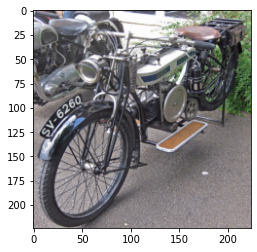

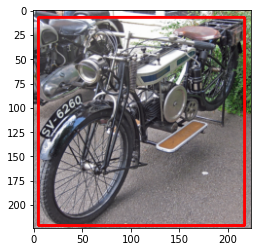

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0   1 107  96]
4


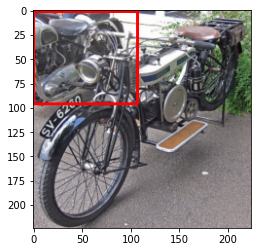

In [13]:
import cv2
from google.colab.patches import cv2_imshow
# Calculate the size and adjusted display size
img_caption,target_detection= coco_val_detection[1]
imgc,_=coco_val[1]
image_height,image_width = img_caption.size
wratio = (224*1.0)/image_width
hratio = (224*1.0)/image_height
img = np.array(torch.transpose(torch.transpose(imgc,0,2),0,1))
plt.figure()
plt.imshow(img)

for i in range(len(target_detection)):

  bbox = target_detection[i]['bbox']
  bbox_plt= bbox_transform_coco2cv(bbox,hratio,wratio)
  print(bbox_plt)
  print(target_detection[i]['category_id'])
  plt.figure()
  k = cv2.rectangle(img,(bbox_plt[0],bbox_plt[1]),(bbox_plt[2],bbox_plt[3]),(255,0,0),2)
  #plt.imshow(k)
  plt.imshow(cv2.UMat.get(k))
  plt.show()



In [14]:
import json
with open("/content/captions_val2014_SAT_results.json") as f:
  prediction = json.load(f)

In [15]:
prediction[0]

{'caption': 'a cat is sitting on a chair with a cat .', 'image_id': 42}

In [16]:
class COCO14Dataset(Dataset):
    def __init__(self,coco,voc,transforms=None):
        self.coco = coco
        self.voc = voc
        self.transforms = transforms
    def __len__(self):
        return len(self.coco)
    def __getitem__(self,idx):
        img,target = self.coco[idx]
        ide = self.coco.ids[idx]

        
        return img,ide

val_dset = COCO14Dataset(coco_val,voc)

In [17]:
def collate_fn(batch):
    data = [item[0] for item in batch]
    images = torch.stack(data,0)
    
    ides = torch.tensor([item[1] for item in batch])
    
    return images, ides



val_loader = DataLoader(val_dset,batch_size = val_batch_size, num_workers = 8,shuffle = False,collate_fn = collate_fn,
                     drop_last=False)

In [18]:
data,ide = iter(val_loader).next()
print(data.shape)

torch.Size([61, 3, 224, 224])


In [19]:
model.load('/content/drive/MyDrive/Research/coco/VGG_encoder_39.pt','/content/drive/MyDrive/Research/coco/VGG_decoder_39.pt')

In [20]:
word_association=pd.read_csv("coco_word_association.csv")
word_association.fillna(value="dummy",inplace=True)

In [21]:
word_association.head(5)

,Category_id,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17
0,1,man,men,woman,women,child,children,kid,kids,girl,girls,boy,boys,male,female,person,dummy,dummy
1,2,bicycles,bicycle,cycles,bike,dummy,dummy,dummy,dummy,dummy,dummy,dummy,dummy,dummy,dummy,dummy,dummy,dummy
2,3,car,cars,van,volkswagon,vehicles,bmw,automobile,suv,dummy,dummy,dummy,dummy,dummy,dummy,dummy,dummy,dummy
3,4,motorcycle,motorcycles,bike,bikes,motorcyclist,motor,scooters,motorbikes,motorized,dummy,dummy,dummy,dummy,dummy,dummy,dummy,dummy
4,5,airplane,plane,bomber,airplanes,air crafts,jets,aircraft,jet,cargo,airliner,glider,bi-plane,dummy,dummy,dummy,dummy,dummy


In [22]:
word_association_dict = {}
for i in tqdm(range(word_association.shape[0])):
  value = list(word_association.loc[i])
  try:
    idx = value.index("dummy")
    value = value[:idx]
    word_association_dict[value[0]] = value[1:]
  except:
    word_association_dict[value[0]] = value[1:]
  #break

100%|██████████| 80/80 [00:00<00:00, 4317.29it/s]


In [23]:
word_association_dict

{1: ['man',
  'men',
  'woman',
  'women',
  'child',
  'children',
  'kid',
  'kids',
  'girl',
  'girls',
  'boy',
  'boys',
  'male',
  'female',
  'person'],
 2: ['bicycles', 'bicycle', 'cycles', 'bike'],
 3: ['car',
  'cars',
  'van',
  'volkswagon ',
  'vehicles',
  'bmw',
  'automobile',
  'suv'],
 4: ['motorcycle',
  'motorcycles',
  'bike',
  'bikes',
  'motorcyclist',
  'motor',
  'scooters',
  'motorbikes',
  'motorized'],
 5: ['airplane',
  'plane',
  'bomber',
  'airplanes',
  'air crafts',
  'jets',
  'aircraft',
  'jet',
  'cargo',
  'airliner',
  'glider',
  'bi-plane'],
 6: ['bus', 'school bus', 'double decker', 'busses', 'vehicles'],
 7: ['train',
  'train engine',
  'cargo train',
  'rails',
  'locomotive',
  'steam engine',
  'train car',
  'diesel train engine',
  'engine'],
 8: ['truck',
  'fire trucks',
  'tow truck',
  'trucks',
  'pickup truck',
  'trailer',
  'vehicles'],
 9: ['boat', 'canoe', 'cargo boat', 'ship', 'trawler', 'sailboats', 'rafts'],
 10: ['traf

In [24]:
attn_weights = []
model.eval()
attention= {}
random_attention = {}
attention_top20 = {}
flag  = 0
with torch.no_grad():
  for data in tqdm(val_loader):
    features, ides= data
    _,cap_txt,attn_wts = model.Greedy_Decoding(features.to(device))
    for j in range(len(cap_txt)): # no of sentences in a batch
      caption = cap_txt[j].split(" ")
      try:
        for cat in category_in_image[ides[j].item()]: 
          for k in range(len(caption)): # no of words in a sentence
            if caption[k] in word_association_dict[cat]:
              focus_weights = attn_wts[k,j] # 196 dimensional attention vector
              bbox_data = bbox_dict[(ides[j].item(),cat)]

              original_box = np.zeros((224,224),dtype=np.uint8)
              attn_box_1 = np.zeros(196,dtype=np.uint8)
              attn_box_2 = np.zeros(196,dtype=np.uint8)
              attn_box_3 = np.zeros(196,dtype=np.uint8)

              max_attn,indices = torch.topk(torch.Tensor(focus_weights),10)
              attn_box_1[indices.numpy()] = 1

              random_indices = np.random.randint(196,size=20)
              attn_box_2[random_indices] = 1

              max_attn2,indices2 = torch.topk(torch.Tensor(focus_weights),20)
              attn_box_3[indices2.numpy()] = 1 
               
              attn_box_1 = np.reshape(attn_box_1,(14,14))
              attn_box_2 = np.reshape(attn_box_2,(14,14))
              attn_box_3 = np.reshape(attn_box_3,(14,14)) 


              attn_box_1 = pyramid_expand(attn_box_1,upscale=16,order=3)
              attn_box_1 = attn_box_1/np.max(attn_box_1)

              attn_box_2 = pyramid_expand(attn_box_2,upscale=16,order=3)
              attn_box_2 = attn_box_2/np.max(attn_box_2)

              attn_box_3 = pyramid_expand(attn_box_3,upscale=16,order=3)
              attn_box_3 = attn_box_3/np.max(attn_box_3)

              
              #print("pyramid expand",attn_box_4.shape)
              image_gt = np.zeros((224,224),dtype=np.uint8)
              for m in range(len(bbox_data)):
                image_gt[bbox_data[m][1]:bbox_data[m][3],bbox_data[m][0]:bbox_data[m][2]] =1.0
              
              nrm_1 = np.linalg.norm(np.reshape(image_gt,(224*224)))
              nrm_2 = np.linalg.norm(np.reshape(attn_box_1,(224*224)))
              nrm_3 = np.linalg.norm(np.reshape(attn_box_2,(224*224)))
              nrm_4 = np.linalg.norm(np.reshape(attn_box_3,(224*224)))

              attention[(ides[j].item(),caption[k])] = np.sum(np.multiply(image_gt,attn_box_1))/(nrm_1*nrm_2)
              random_attention[(ides[j].item(),caption[k])] = np.sum(np.multiply(image_gt,attn_box_2))/(nrm_1*nrm_3)
              attention_top20[(ides[j].item(),caption[k])] = np.sum(np.multiply(image_gt,attn_box_3))/(nrm_1*nrm_4)
      except:
        flag= flag +1            


100%|██████████| 664/664 [48:37<00:00,  4.39s/it]


In [25]:
print(flag)

367


In [26]:
print("random_attention 20 ",np.mean(list(random_attention.values())), "model_attention",np.mean(list(attention.values())),"model_attention_top20",np.mean(list(attention_top20.values())))

random_attention 20  0.24037512529768937 model_attention 0.3674863043467919 model_attention_top20 0.42921879914260214


In [27]:
len(random_attention),len(attention),len(attention_top20)

(49819, 49819, 49819)